<h1>This is the individual model:Simple_model_1Individual test,. Categorical!!!</h1>
<h1>Completed</h1>

In [1]:
import os
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization,Activation, concatenate, DepthwiseConv2D, Multiply,Dropout
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D,Flatten, Layer,BatchNormalization, Add,Reshape,AveragePooling2D

from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



In [2]:
input_shape = (224, 224, 3)

train_dir = '/root/DRD_Split_Cloud/DRD_Split/train'
test_dir = '/root/DRD_Split_Cloud/DRD_Split/test'
batch_size = 8
num_classes = 2
# filter_factor = 8

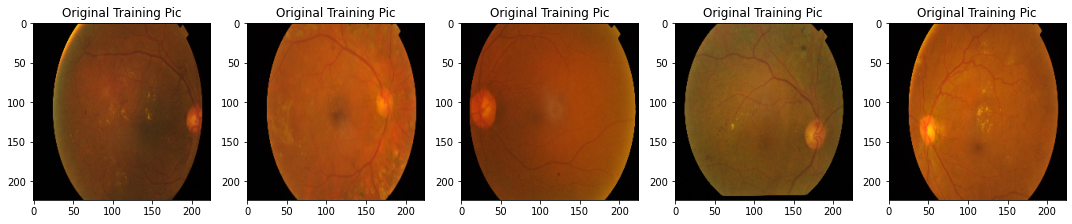

In [3]:
train_diabetic = '/root/DRD_Split_Cloud/DRD_Split/train/diabetic'

#Show the import original image
train_img_files = os.listdir(train_diabetic)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_diabetic, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)




Found 2708 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


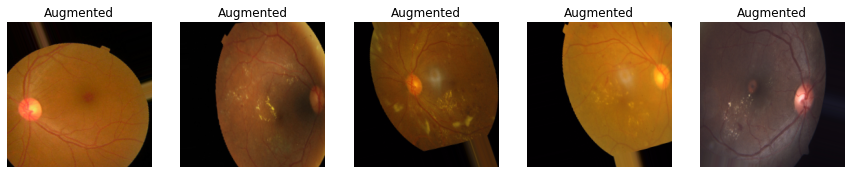

In [5]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [9]:
def simple_model_1(input_shape):
    inputs = Input(shape = input_shape)
    #Input convolution
    x = Conv2D(64, (3, 3), activation = 'leaky_relu',
               padding = 'same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
 
    x = MaxPooling2D(2, 2)(x)
    
    #First Dethwise Convolution
    x = Conv2D(64, (3, 3),  
               padding = 'same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(2, 2)(x)

    
    #Second convolutional layer
    x = Conv2D(32, (3, 3), 
               padding = 'same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(2, 2)(x)
    
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation = 'softmax')(x)
    model_1 = Model(inputs, outputs)
    
    return model_1


simple_model_1 = simple_model_1(input_shape)



simple_model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 batch_normalization_4 (Batc  (None, 112, 112, 64)     256 

In [10]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score

simple_model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', 
        Precision(), 
        Recall(), 
        AUC(), 
        F1Score(num_classes=2, average = 'micro')
    ]
)
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)



In [11]:
history = simple_model_1.fit(train_generator, epochs = 100, validation_data=(validation_generator), callbacks = [lr_reduction])

Epoch 1/100


2023-12-09 10:42:32.098336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-09 10:42:33.447058: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


339/339 [==============================] - 33s 89ms/step - loss: 0.4870 - accuracy: 0.7755 - precision_1: 0.7755 - recall_1: 0.7755 - auc_1: 0.8501 - f1_score: 0.7753 - val_loss: 1.2203 - val_accuracy: 0.5099 - val_precision_1: 0.5099 - val_recall_1: 0.5099 - val_auc_1: 0.6574 - val_f1_score: 0.3422 - lr: 0.0010
Epoch 2/100
339/339 [==============================] - 30s 89ms/step - loss: 0.3672 - accuracy: 0.8667 - precision_1: 0.8667 - recall_1: 0.8667 - auc_1: 0.9210 - f1_score: 0.8667 - val_loss: 0.6197 - val_accuracy: 0.6064 - val_precision_1: 0.6064 - val_recall_1: 0.6064 - val_auc_1: 0.7551 - val_f1_score: 0.5464 - lr: 0.0010
Epoch 3/100
339/339 [==============================] - 30s 88ms/step - loss: 0.3364 - accuracy: 0.8778 - precision_1: 0.8778 - recall_1: 0.8778 - auc_1: 0.9320 - f1_score: 0.8777 - val_loss: 0.2924 - val_accuracy: 0.8936 - val_precision_1: 0.8936 - val_recall_1: 0.8936 - val_auc_1: 0.9606 - val_f1_score: 0.8932 - lr: 0.0010
Epoch 4/100
339/339 [=============

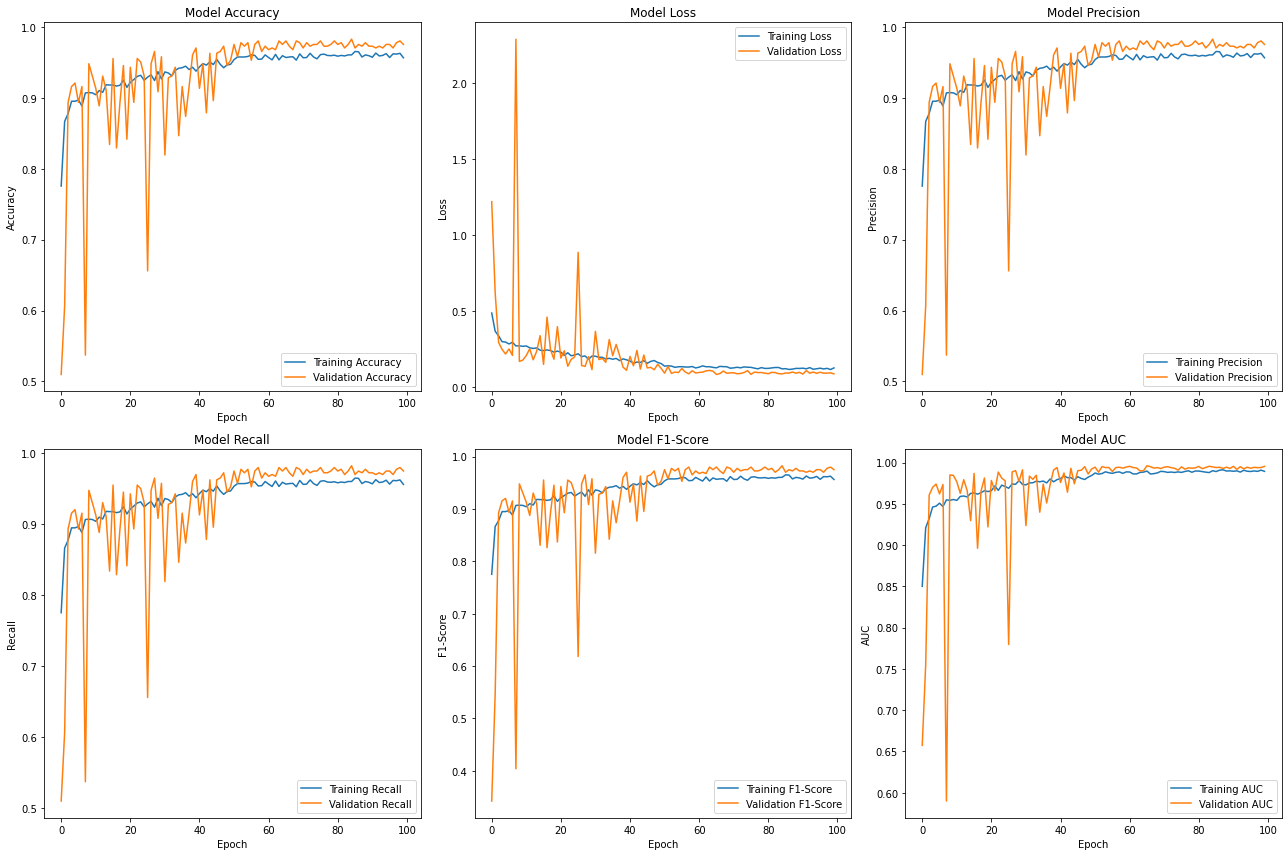

In [14]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

17/17 [==============================] - 1s 17ms/step


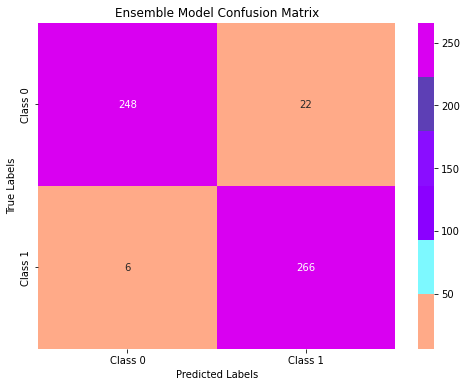

In [17]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize lists to collect images and true labels
collected_images = []
collected_true_labels = []

# Use a traditional for loop to collect images and labels
for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    collected_images.append(images)
    collected_true_labels.append(true_labels)

# Concatenate the lists of images and labels
collected_images = np.concatenate(collected_images)
collected_true_labels = np.argmax(np.concatenate(collected_true_labels), axis=1)

# Make predictions and get predicted labels
ensemble_predictions = simple_model_1.predict(collected_images)
ensemble_predicted_labels = np.argmax(ensemble_predictions, axis=1)

# Generate and plot confusion matrix
ensemble_conf_matrix = confusion_matrix(collected_true_labels, ensemble_predicted_labels)
plt.figure(figsize=(8, 6))

#customizae color
amethyst_palette = sns.color_palette([
    "#FFAA88",  
    "#7DF9FF",  
    "#8B00FF",  
    "#8A0DFF",  
    "#5D3FB5",  
    "#D900F1"   
])
sns.heatmap(ensemble_conf_matrix, 
            annot=True, 
            fmt="d", 
            cmap=amethyst_palette, 
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])

plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


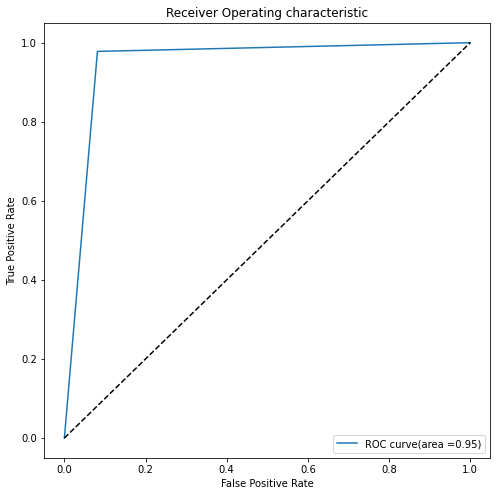

In [18]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(collected_true_labels, ensemble_predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [19]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)



sensitivity: 0.9779411764705882
specificity: 0.9185185185185185


17/17 [==============================] - 0s 11ms/step


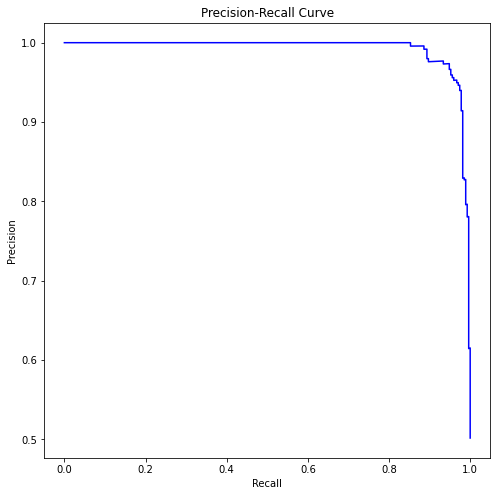

In [20]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs = simple_model_1.predict(collected_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(collected_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [24]:
from sklearn.metrics import classification_report
# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = simple_model_1.predict(collected_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(collected_true_labels, y_pred_labels)
print(report)

17/17 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       270
           1       0.92      0.98      0.95       272

    accuracy                           0.95       542
   macro avg       0.95      0.95      0.95       542
weighted avg       0.95      0.95      0.95       542



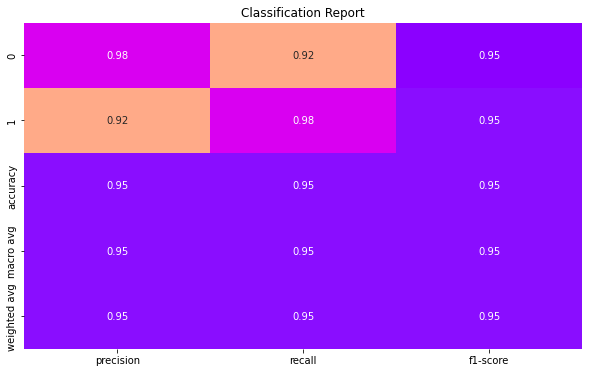

In [25]:
import pandas as pd



# 生成分类报告
report = classification_report(collected_true_labels, y_pred_labels, output_dict=True)

# 转换为 DataFrame
report_df = pd.DataFrame(report).transpose()

# 删除支持列，因为它不适合于热力图
report_df = report_df.drop(columns=['support'])

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap=amethyst_palette, cbar=False)
plt.title("Classification Report")
plt.show()


In [27]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = simple_model_1.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

69/69 [==============================] - 1s 19ms/step - loss: 0.1328 - accuracy: 0.9473 - precision_1: 0.9473 - recall_1: 0.9473 - auc_1: 0.9891 - f1_score: 0.9473
Test loss: 0.13280712068080902
Test accuracy: 0.9472727179527283
Test precision: 0.9472727179527283
Test recall: 0.9472727179527283
Test AUC: 0.9890643954277039
Test F1 Score: 0.9472585916519165


In [29]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

del simple_model_1


from numba import cuda

cuda.select_device(0)
cuda.close()